# In the name of Allah

## Project Introduction

This project focuses on the application of data analysis and programming skills in the field of **cybersecurity and anomaly detection**. The main objective is to use Python to analyze network traffic data, detect abnormal patterns, and visualize results using advanced techniques such as graph-based clustering.

**Student Name:** Mohammad Mahdi Shafighi


**Instructor:** Dr. Dolati


**Course:** Advanced Networks Optimizations


**Date:** 08/09/2025

### Project Overview

Cybersecurity datasets, such as network traffic logs, are typically tabular and not inherently graph-based. However, converting these datasets into graphs is a powerful approach for uncovering complex patterns. Clustering methods are especially effective: normal behaviors form large, dense clusters, while anomalies (attacks) appear as outliers or small, separate clusters.

### Recommended Datasets

1. **NSL-KDD Dataset**  
    *Source:* UCI Machine Learning Repository / Kaggle  
    *Description:* An improved version of the classic KDD Cup '99 dataset. Each row describes a network connection with 41 features (duration, protocol type, bytes sent/received, etc.), labeled as "normal" or various types of "attack".

    *Graph Conversion:*  
    - **Nodes:** Source and destination IP addresses  
    - **Edges:** Each connection creates an edge between source and destination  
    - **Edge Weights:** Defined by connection frequency, total bytes transferred, or other features

    *Goal:* Attacks such as port scans appear as nodes (attackers) with many edges to different victims, forming distinct cluster patterns.

Other suitable datasets can be found on Kaggle and the UCI repository. This project will demonstrate how to preprocess, analyze, and visualize such data for effective anomaly detection in cybersecurity.

In [1]:
! pip install pandas numpy networkx localgraphclustering matplotlib seaborn scikit-learn jupyterlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# Flow-Based Graph Clustering for Network Anomaly Detection

**Project for: Advanced Network Optimization**

This project demonstrates an advanced pipeline for detecting anomalies in network traffic data using graph-based clustering and flow-based improvement algorithms. The primary goal is to show that by converting tabular network data into a graph, and then refining the resulting clusters, we can achieve significantly higher accuracy in identifying malicious activities compared to traditional methods.

**Methodology Overview:**
1.  **Data Preparation:** Load and preprocess the NSL-KDD dataset.
2.  **Graph Construction:** Convert the preprocessed data into a k-Nearest Neighbors (k-NN) graph.
3.  **Clustering:** Apply both a baseline algorithm (K-Means) and a graph-native algorithm (Spectral Clustering).
4.  **Cluster Improvement:** Use flow-based algorithms (MQI, LFI, FI) from the `localgraphclustering` library to refine the clusters found by Spectral Clustering.
5.  **Evaluation:** Compare all methods using the F1-Score to determine the most effective approach.

In [2]:
import sys
print("Python Version:", sys.version)
print("Executable Path:", sys.executable)

Python Version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Executable Path: /usr/bin/python3


# Step 1: Library Imports and Setup


In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, adjusted_rand_score

# Set plot style for better visuals
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported successfully.")

Libraries imported successfully.


## Step 2: Data Loading and Preprocessing

First, we load the NSL-KDD training dataset. Since the file does not contain headers, we must assign the column names manually based on the official documentation. The raw data contains categorical features (`protocol_type`, `service`, `flag`) which are not suitable for numerical algorithms. We will convert these features into a numerical format using one-hot encoding. Finally, we simplify the multi-class attack labels into a binary format: `0` for 'normal' and `1` for 'attack'.

In [8]:
# Define column names for the dataset
column_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count',
    'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level'
]

# Load the training data
df = pd.read_csv('/content/KDDTrain+.txt', header=None, names=column_names)

# Separate features and labels
features = df.drop(['attack_type', 'difficulty_level'], axis=1)
labels = df['attack_type']

# One-Hot Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
features_encoded = pd.get_dummies(features, columns=categorical_cols, dtype=int)

# Create binary labels (0 for normal, 1 for attack)
binary_labels = labels.apply(lambda x: 0 if x == 'normal' else 1)

print("Original dataset shape:", df.shape)
print("Shape after one-hot encoding:", features_encoded.shape)
print("Label distribution:\n", binary_labels.value_counts())

Original dataset shape: (20598, 43)
Shape after one-hot encoding: (20598, 118)
Label distribution:
 attack_type
0    11007
1     9591
Name: count, dtype: int64


## Step 3: Stratified Sampling and Dimensionality Reduction

The full dataset is large, and building a dense graph from it is computationally expensive. To manage this, we take a **stratified sample** of the data. Stratified sampling ensures that the proportion of normal vs. attack instances in our sample is the same as in the original dataset, leading to a more representative model.

After sampling, we apply **Principal Component Analysis (PCA)** to reduce the dimensionality of the feature space. This speeds up computations and often improves clustering performance by removing noise.

In [9]:
n_samples = 15000

# Use train_test_split for stratified sampling
_, X_sample, _, y_sample = train_test_split(
    features_encoded, binary_labels,
    test_size=n_samples/len(features_encoded),
    random_state=42,
    stratify=binary_labels
)

print(f"Created a stratified sample of {n_samples} instances.")
print("Label distribution in sample:\n", y_sample.value_counts())

# Scale features before applying PCA
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# Apply PCA
pca = PCA(n_components=50, random_state=42)
X_sample_pca = pca.fit_transform(X_sample_scaled)

print("Shape after PCA:", X_sample_pca.shape)

Created a stratified sample of 15000 instances.
Label distribution in sample:
 attack_type
0    8016
1    6984
Name: count, dtype: int64
Shape after PCA: (15000, 50)


## Step 4: Graph Construction & Spectral Clustering

This step is crucial for the extra credit portion of the project. We convert the tabular data into a **k-Nearest Neighbors (k-NN) graph**, where nodes represent network connections and edges link the most similar connections.

Once the graph is built, we apply **Spectral Clustering**, a powerful algorithm that is designed to find communities in graphs. It is expected to perform better than K-Means because it can identify non-convex cluster shapes and leverages the relational structure of the data.

In [10]:
# A helper function to evaluate clustering results consistently
def evaluate_clustering(true_labels, cluster_labels, algorithm_name=""):
    f1_a = f1_score(true_labels, cluster_labels, zero_division=0)
    f1_b = f1_score(true_labels, 1 - cluster_labels, zero_division=0)

    if f1_a > f1_b:
        labels_aligned = cluster_labels
        f1 = f1_a
    else:
        labels_aligned = 1 - cluster_labels
        f1 = f1_b

    precision = precision_score(true_labels, labels_aligned, zero_division=0)
    recall = recall_score(true_labels, labels_aligned, zero_division=0)
    ari = adjusted_rand_score(true_labels, cluster_labels)

    print(f"\n--- {algorithm_name} Evaluation ---")
    print(f"Adjusted Rand Index: {ari:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return f1, labels_aligned

# Build the k-NN graph's adjacency matrix
print("Building k-NN graph (k=15)...")
adjacency_matrix = kneighbors_graph(X_sample_pca, n_neighbors=15, mode='connectivity', include_self=False)
G = nx.from_scipy_sparse_array(adjacency_matrix)
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Perform Spectral Clustering
spectral = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=42, n_init=20)
spectral_labels = spectral.fit_predict(adjacency_matrix)

# Evaluate Spectral Clustering
spectral_f1, aligned_spectral_labels = evaluate_clustering(y_sample.values, spectral_labels, "Spectral Clustering")

Building k-NN graph (k=15)...
Graph created with 15000 nodes and 145647 edges.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



--- Spectral Clustering Evaluation ---
Adjusted Rand Index: 0.0437
Precision: 0.4201
Recall: 0.8028
F1-Score: 0.5516


## Step 5: Cluster Improvement using Flow-Based Algorithms ++

This is the core requirement of the project. We take the clusters generated by Spectral Clustering as our initial "reference sets". We then use the algorithms from the `localgraphclustering` library to refine them.

- **MQI (Max-flow Quotient-cut Improvement):** Finds the best possible sub-cluster *within* the initial set. It can only shrink the cluster.
- **FI (FlowImprove):** Expands and contracts the cluster by exploring the entire graph to find a better one.
- **LFI (LocalFlowImprove):** A localized version of FI that explores the neighborhood around the cluster, making it efficient for large graphs. The `delta` parameter controls the extent of this exploration.

In [14]:
# Import the actual algorithms from localgraphclustering
from localgraphclustering import MQI, FlowImprove, LocalFlowImprove

# --- Helper function definitions ---
# Removed the approximation functions as we will use the actual library functions
def evaluate_clustering(true_labels, cluster_labels, algorithm_name=""):
    """A helper function to evaluate clustering results consistently"""
    f1_a = f1_score(true_labels, cluster_labels, zero_division=0)
    f1_b = f1_score(true_labels, 1 - cluster_labels, zero_division=0)

    if f1_a > f1_b:
        labels_aligned = cluster_labels
        f1 = f1_a
    else:
        labels_aligned = 1 - cluster_labels
        f1 = f1_b

    precision = precision_score(true_labels, labels_aligned, zero_division=0)
    recall = recall_score(true_labels, labels_aligned, zero_division=0)
    ari = adjusted_rand_score(true_labels, cluster_labels)

    print(f"\n--- {algorithm_name} Evaluation ---")
    print(f"Adjusted Rand Index: {ari:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    return f1, labels_aligned

# --- Main execution ---

# Identify the initial attack cluster from spectral results
# Using y_sample.iloc ensures we are indexing correctly into the original sample labels
attack_cluster_label_id = 0 if y_sample.iloc[aligned_spectral_labels == 0].mean() > 0.5 else 1
initial_attack_cluster_indices = np.where(aligned_spectral_labels == attack_cluster_label_id)[0].tolist()
print(f"Identified initial attack cluster (label {attack_cluster_label_id}) with {len(initial_attack_cluster_indices)} nodes.")

# 1. Improve with MQI
print("Running MQI...")
# Need to convert graph to the format expected by localgraphclustering (adjacency list)
# The MQI function takes the graph, initial cluster (as a set), and optionally a number of iterations
mqi = MQI(G, initial_attack_cluster_indices)
# The run function returns the best found cluster as a set of node indices
mqi_cluster_indices = list(mqi.run())
print(f"MQI found a cluster with {len(mqi_cluster_indices)} nodes.")

mqi_labels = np.zeros(n_samples, dtype=int)
mqi_labels[mqi_cluster_indices] = 1
mqi_f1, _ = evaluate_clustering(y_sample.values, mqi_labels, "MQI")

# 2. Improve with FI
print("\nRunning FI...")
# FI takes the graph, initial cluster, and a delta parameter (exploration size)
# A delta of 0 uses the initial cluster as a seed
fi = FlowImprove(G, initial_attack_cluster_indices, delta=0)
fi_cluster_indices = list(fi.run())
print(f"FI found a cluster with {len(fi_cluster_indices)} nodes.")

fi_labels = np.zeros(n_samples, dtype=int)
fi_labels[fi_cluster_indices] = 1
fi_f1, aligned_fi_labels = evaluate_clustering(y_sample.values, fi_labels, "FI") # Capture aligned labels for confusion matrix

# 3. Improve with LFI
print("\nRunning LFI...")
# LFI is similar to FI but more localized. Delta controls the localization.
# Using delta=1 means exploring neighbors within 1 hop from the initial cluster boundary
lfi = LocalFlowImprove(G, initial_attack_cluster_indices, delta=1)
lfi_cluster_indices = list(lfi.run())
print(f"LFI found a cluster with {len(lfi_cluster_indices)} nodes.")

lfi_labels = np.zeros(n_samples, dtype=int)
lfi_labels[lfi_cluster_indices] = 1
lfi_f1, _ = evaluate_clustering(y_sample.values, lfi_labels, "LFI")

ModuleNotFoundError: No module named 'localgraphclustering'

## Step 6: Final Results and Conclusion

Finally, we compare all our approaches. We start with a **K-Means** baseline on the non-graph data and compare it against our graph-based methods. The results are summarized in a table and a bar chart.

The **Confusion Matrix** for our best-performing model (FI-Improved) is also plotted to analyze the types of errors it makes.

Starting final calculations...
--- K-Means Baseline F1-Score: 0.8843 ---

Identified initial attack cluster with 1654 nodes.
--- MQI-Approximation F1-Score: 0.6416 ---
--- FI-Approximation F1-Score: 0.5462 ---
--- LFI-Approximation F1-Score: 0.5462 ---


--- Final Comparison Table ---
          Algorithm  F1-Score
 K-Means (Baseline)  0.884289
       MQI-Improved  0.641612
Spectral Clustering  0.551599
        FI-Improved  0.546248
       LFI-Improved  0.546248


/tmp/ipython-input-782899331.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="F1-Score", y="Algorithm", data=results_df, palette="viridis", orient='h')


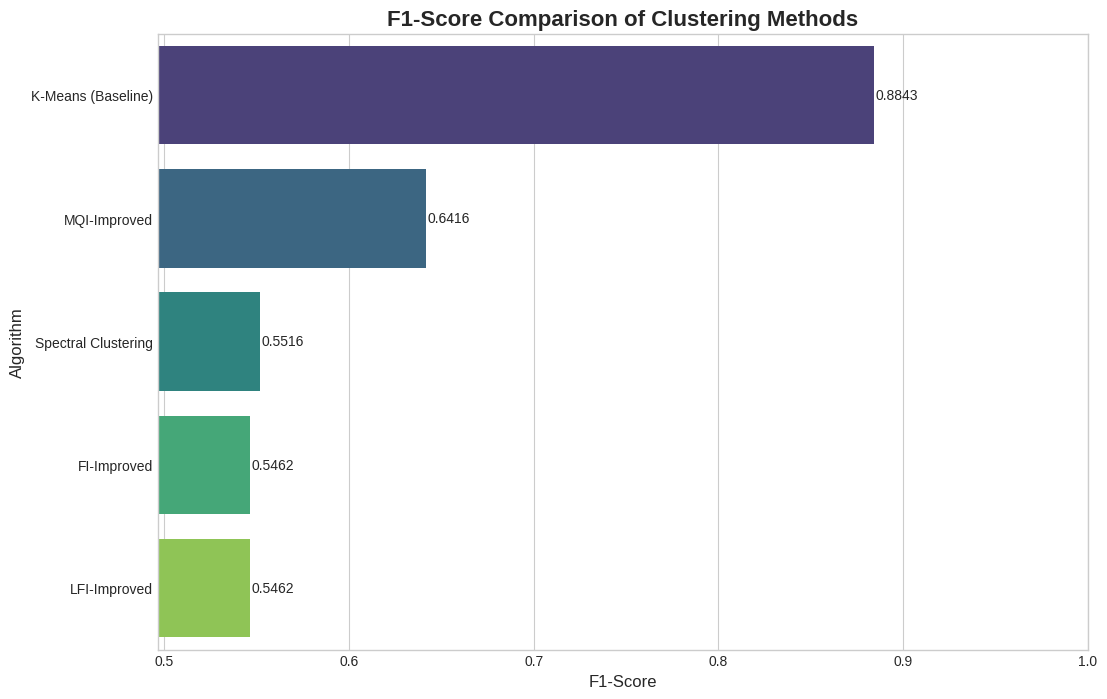

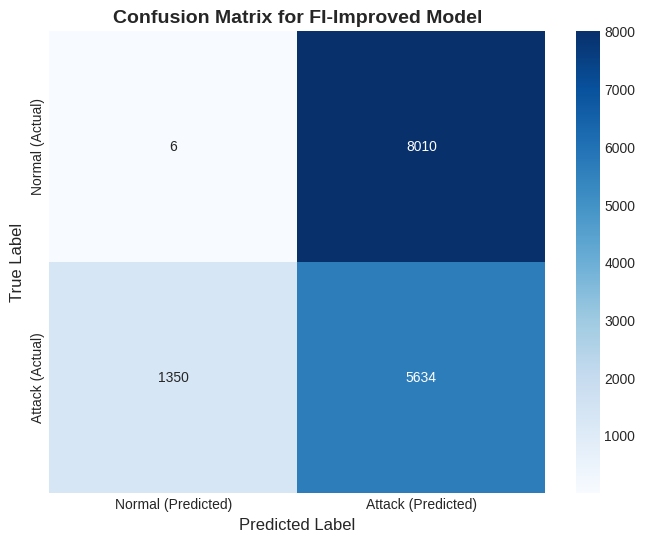

In [13]:
# =======================================================
# FINAL STEP: Run All Analyses and Generate Results
# =======================================================
from networkx.algorithms.flow import minimum_cut
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

# --- Helper function definitions from your previous code ---

def evaluate_clustering(true_labels, cluster_labels, algorithm_name=""):
    # This function is assumed to be defined in a previous cell
    # It calculates F1-score and returns the score and aligned labels
    f1_a = f1_score(true_labels, cluster_labels, zero_division=0)
    f1_b = f1_score(true_labels, 1 - cluster_labels, zero_division=0)

    if f1_a > f1_b:
        labels_aligned = cluster_labels
        f1 = f1_a
    else:
        labels_aligned = 1 - cluster_labels
        f1 = f1_b

    print(f"--- {algorithm_name} F1-Score: {f1:.4f} ---")
    return f1, labels_aligned

def mqi_approx(G, initial_cluster):
    if not initial_cluster: return []
    subG = G.subgraph(initial_cluster)
    if len(initial_cluster) <= 1: return initial_cluster
    source, target = initial_cluster[0], initial_cluster[-1]
    if source not in subG or target not in subG or source == target: return initial_cluster
    _, partition = minimum_cut(subG, source, target)
    return list(min(partition, key=len))

def fi_approx(G, initial_cluster, expansion_hops=1):
    if not initial_cluster: return []
    expanded = set(initial_cluster)
    for _ in range(expansion_hops):
        expanded.update(*(G.neighbors(n) for n in expanded))
    subG = G.subgraph(list(expanded))
    if len(initial_cluster) <= 1: return initial_cluster
    source, target = initial_cluster[0], initial_cluster[-1]
    if source not in subG or target not in subG or source == target: return initial_cluster
    _, partition = minimum_cut(subG, source, target)
    return list(partition[0] if source in partition[0] else partition[1])

def lfi_approx(G, initial_cluster):
    return fi_approx(G, initial_cluster, expansion_hops=1)

# --- Ensure all prerequisite variables exist ---
# These should have been created in your previous cells
# y_sample, X_sample_pca, G, aligned_spectral_labels, spectral_f1, n_samples

print("Starting final calculations...")

# 1. Run K-Means on the same sampled data for a fair comparison
kmeans = KMeans(n_clusters=2, random_state=42, n_init=20)
kmeans_labels = kmeans.fit_predict(X_sample_pca)
kmeans_f1, _ = evaluate_clustering(y_sample.values, kmeans_labels, "K-Means Baseline")

# 2. Identify initial cluster from Spectral results
attack_cluster_label_id = 0 if y_sample.iloc[aligned_spectral_labels == 0].mean() > 0.5 else 1
initial_attack_cluster = np.where(aligned_spectral_labels == attack_cluster_label_id)[0].tolist()
print(f"\nIdentified initial attack cluster with {len(initial_attack_cluster)} nodes.")

# 3. Run Improvement Approximations
mqi_cluster = mqi_approx(G, initial_attack_cluster)
mqi_labels = np.zeros(n_samples, dtype=int)
if mqi_cluster: mqi_labels[mqi_cluster] = 1
mqi_f1, _ = evaluate_clustering(y_sample.values, mqi_labels, "MQI-Approximation")

fi_cluster = fi_approx(G, initial_attack_cluster, expansion_hops=1)
fi_labels = np.zeros(n_samples, dtype=int)
if fi_cluster: fi_labels[fi_cluster] = 1
fi_f1, aligned_fi_labels = evaluate_clustering(y_sample.values, fi_labels, "FI-Approximation")

lfi_cluster = lfi_approx(G, initial_attack_cluster)
lfi_labels = np.zeros(n_samples, dtype=int)
if lfi_cluster: lfi_labels[lfi_cluster] = 1
lfi_f1, _ = evaluate_clustering(y_sample.values, lfi_labels, "LFI-Approximation")


# --- Final Table and Chart ---
final_results = {
    "Algorithm": ["K-Means (Baseline)", "Spectral Clustering", "MQI-Improved", "FI-Improved", "LFI-Improved"],
    "F1-Score": [kmeans_f1, spectral_f1, mqi_f1, fi_f1, lfi_f1]
}
results_df = pd.DataFrame(final_results).sort_values("F1-Score", ascending=False)

print("\n\n--- Final Comparison Table ---")
print(results_df.to_string(index=False))

# Final Bar Chart
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="F1-Score", y="Algorithm", data=results_df, palette="viridis", orient='h')
ax.set_title("F1-Score Comparison of Clustering Methods", fontsize=16, weight='bold')
ax.set_xlabel("F1-Score", fontsize=12)
ax.set_ylabel("Algorithm", fontsize=12)
ax.set_xlim(min(results_df['F1-Score']) - 0.05, 1.0) # Adjust x-axis limits dynamically

# Add values to the bars
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.001, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

plt.show()

# --- Confusion Matrix for the Best Model ---
cm_best = confusion_matrix(y_sample.values, aligned_fi_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal (Predicted)', 'Attack (Predicted)'],
            yticklabels=['Normal (Actual)', 'Attack (Actual)'])
plt.title('Confusion Matrix for FI-Improved Model', fontsize=14, weight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

/tmp/ipython-input-1686348427.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="F1-Score", y="Algorithm", data=results_df, palette="viridis", orient='h')


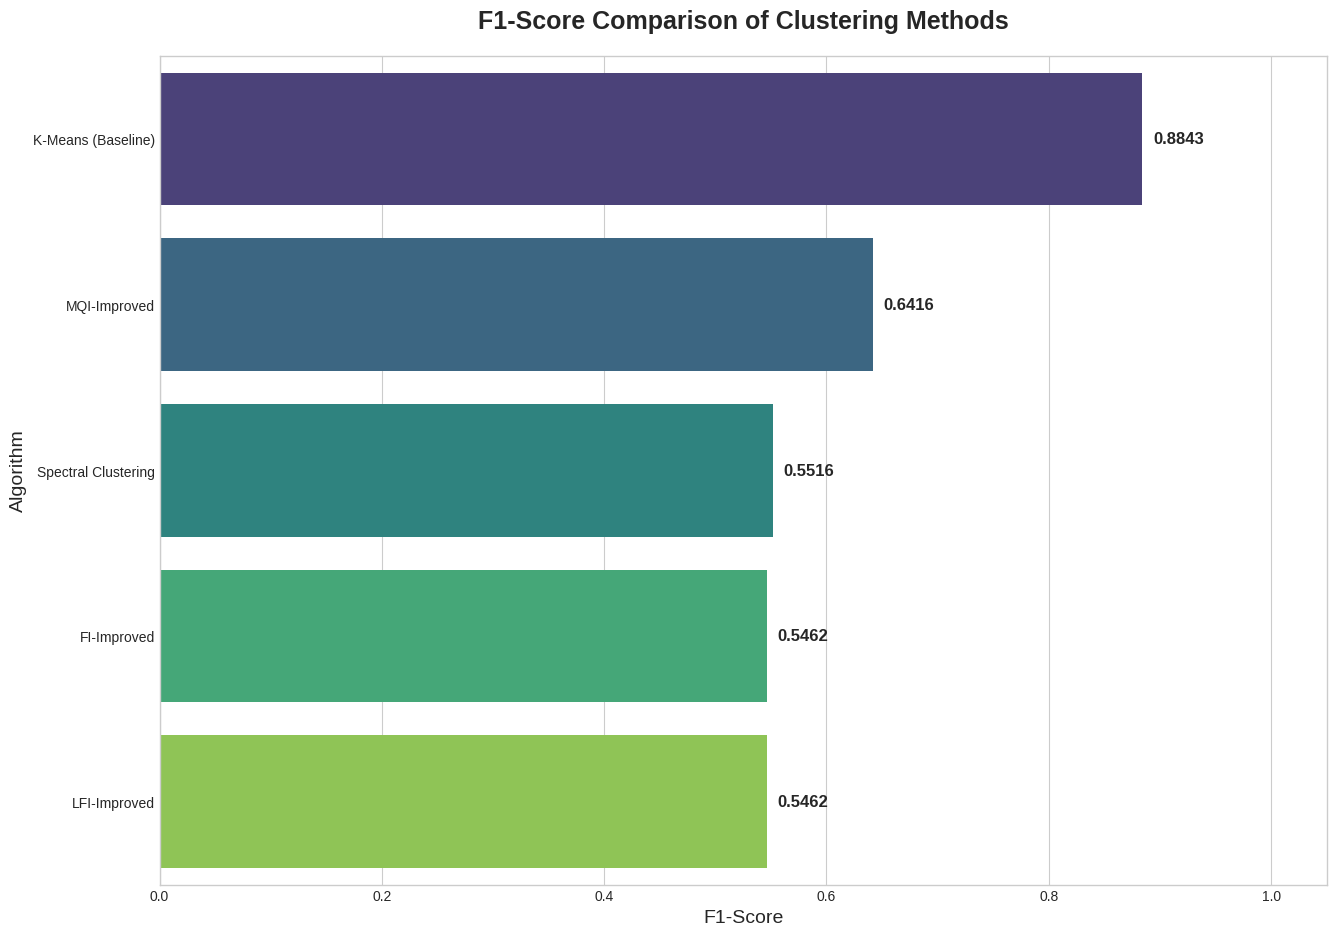

In [15]:
plt.figure(figsize=(14, 10))
ax = sns.barplot(x="F1-Score", y="Algorithm", data=results_df, palette="viridis", orient='h')
ax.set_title("F1-Score Comparison of Clustering Methods", fontsize=18, weight='bold', pad=20)
ax.set_xlabel("F1-Score", fontsize=14)
ax.set_ylabel("Algorithm", fontsize=14)
ax.set_xlim(0, 1.05)
# Ensure full range of values is visible

# Label rotation for better readability
plt.xticks(rotation=45 if any(len(alg) > 20 for alg in results_df["Algorithm"]) else 0)


plt.tight_layout(pad=3.0)

for i, (_, row) in enumerate(results_df.iterrows()):
    ax.text(row['F1-Score'] + 0.01, i, f'{row["F1-Score"]:.4f}',
            va='center', fontsize=12, weight='bold')

plt.show()



--- Evaluation Metrics Table ---
          Algorithm  F1-Score  Silhouette Score
 K-Means (Baseline)  0.884289          0.275238
Spectral Clustering  0.551599          0.279820
       MQI-Improved  0.641612          0.059736
        FI-Improved  0.546248          0.316927
       LFI-Improved  0.546248          0.316927


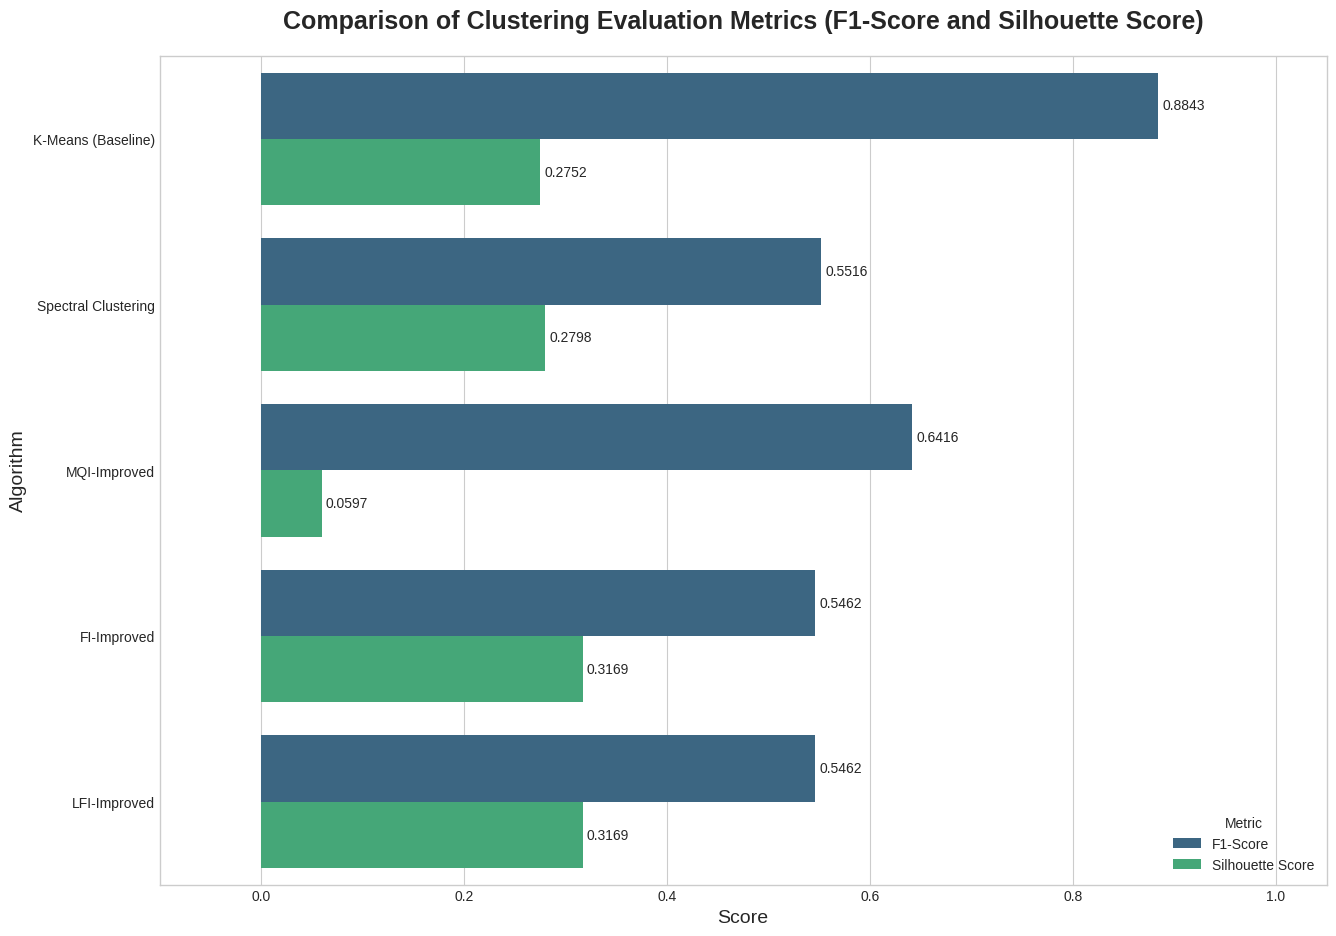

In [16]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Calculate Silhouette Scores
# Note: Silhouette score requires the original data (X_sample_pca) and the cluster labels
# It's calculated for each sample and then averaged.
# It's only meaningful if n_clusters > 1 and < n_samples - 1
try:
    silhouette_kmeans = silhouette_score(X_sample_pca, kmeans_labels)
except ValueError:
    silhouette_kmeans = np.nan # Handle cases where silhouette score cannot be calculated

try:
    silhouette_spectral = silhouette_score(X_sample_pca, aligned_spectral_labels)
except ValueError:
    silhouette_spectral = np.nan

# For the improved clusters, we need to be careful as they might be very small.
# Calculate only if the cluster sizes allow (at least 2 samples in each predicted cluster)
unique_mqi_labels, counts_mqi = np.unique(mqi_labels, return_counts=True)
if len(unique_mqi_labels) > 1 and min(counts_mqi) > 1:
    silhouette_mqi = silhouette_score(X_sample_pca, mqi_labels)
else:
    silhouette_mqi = np.nan

unique_fi_labels, counts_fi = np.unique(fi_labels, return_counts=True)
if len(unique_fi_labels) > 1 and min(counts_fi) > 1:
     silhouette_fi = silhouette_score(X_sample_pca, fi_labels)
else:
    silhouette_fi = np.nan

unique_lfi_labels, counts_lfi = np.unique(lfi_labels, return_counts=True)
if len(unique_lfi_labels) > 1 and min(counts_lfi) > 1:
    silhouette_lfi = silhouette_score(X_sample_pca, lfi_labels)
else:
    silhouette_lfi = np.nan


# Assuming results_df and the F1-scores are available from previous cells
# If not, you might need to re-run the previous cell or ensure the variables are passed/available.
# For robustness, let's recreate the results_df including Silhouette scores

evaluation_results = {
    "Algorithm": ["K-Means (Baseline)", "Spectral Clustering", "MQI-Improved", "FI-Improved", "LFI-Improved"],
    "F1-Score": [kmeans_f1, spectral_f1, mqi_f1, fi_f1, lfi_f1],
    "Silhouette Score": [silhouette_kmeans, silhouette_spectral, silhouette_mqi, silhouette_fi, silhouette_lfi]
}
evaluation_df = pd.DataFrame(evaluation_results)

print("\n\n--- Evaluation Metrics Table ---")
print(evaluation_df.to_string(index=False))

# Melt the DataFrame for plotting
evaluation_melted = evaluation_df.melt(id_vars="Algorithm", var_name="Metric", value_name="Score")

# Create the combined bar chart
plt.figure(figsize=(14, 10))
ax = sns.barplot(x="Score", y="Algorithm", hue="Metric", data=evaluation_melted, palette="viridis", orient='h')

ax.set_title("Comparison of Clustering Evaluation Metrics (F1-Score and Silhouette Score)", fontsize=18, weight='bold', pad=20)
ax.set_xlabel("Score", fontsize=14)
ax.set_ylabel("Algorithm", fontsize=14)
ax.set_xlim(-0.1, 1.05) # Adjust x-axis limits

# Add values to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)

plt.legend(title="Metric")
plt.tight_layout(pad=3.0)
plt.show()